## Imports + file path

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("/Users/admin/anomaly-detection-api/data/raw/NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv")

path.exists() #check if file is downloaded and ready

True

## Read and inspect the dataset

### Loading the dataset

In [10]:
df = pd.read_csv(path)
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


## EDA

### Shape + columns

In [13]:
df.shape, df.columns

((4032, 2), Index(['timestamp', 'value'], dtype='object'))

## Clean timestamps + sort

In [16]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [18]:
df["value"].describe()

count    4032.000000
mean        0.126303
std         0.094813
min         0.066000
25%         0.132000
50%         0.134000
75%         0.134000
max         2.344000
Name: value, dtype: float64

## Plot series

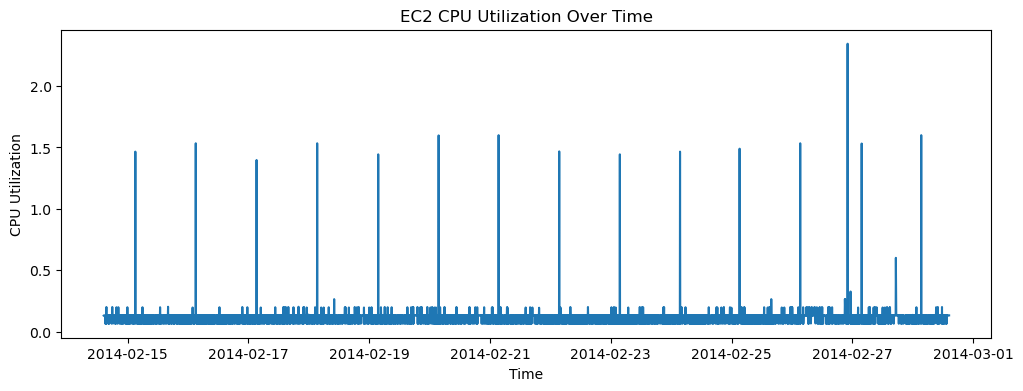

In [45]:
# Create plots directory 
PLOTS_DIR = Path("/Users/admin/plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["value"])
plt.title("EC2 CPU Utilization Over Time")
plt.xlabel("Time")
plt.ylabel("CPU Utilization")

# Save the plot
plt.savefig(PLOTS_DIR / "00_raw_ec2_cpu_timeseries.png", dpi=200, bbox_inches="tight")
plt.show()

### The EC2 CPU utilization time series shows a low and stable baseline for most of the observation period, indicating normal system operation. This baseline is occasionally interrupted by sharp, isolated spikes, where CPU usage increases dramatically for short durations.

### These spikes represent unusual workload events that deviate significantly from typical behavior and are strong candidates for anomalies. This raw visualization establishes a clear motivation for anomaly detection and serves as a baseline reference before applying feature engineering and machine learning models.

In [29]:
df.isna().sum(), df.duplicated().sum() #Missing values + duplicates

(timestamp    0
 value        0
 dtype: int64,
 0)

In [27]:
df.sort_values("value", ascending=False).head(10) #Largest spikes (top 10)

,timestamp,value
3547,2014-02-26 22:05:00,2.344
3898,2014-02-28 03:20:00,1.600
1883,2014-02-21 03:25:00,1.600
1597,2014-02-20 03:35:00,1.598
1018,2014-02-18 03:20:00,1.534
3321,2014-02-26 03:15:00,1.534
439,2014-02-16 03:05:00,1.534
3614,2014-02-27 03:40:00,1.532
3032,2014-02-25 03:10:00,1.490
2172,2014-02-22 03:30:00,1.468


## Feature Engineering

In [33]:
# Create rolling statistics
df_feat = df.copy()

df_feat["rolling_mean_5"] = df_feat["value"].rolling(window=5).mean()
df_feat["rolling_std_5"] = df_feat["value"].rolling(window=5).std()

df_feat["rolling_mean_20"] = df_feat["value"].rolling(window=20).mean()
df_feat["rolling_std_20"] = df_feat["value"].rolling(window=20).std()

df_feat.head(10)

,timestamp,value,rolling_mean_5,rolling_std_5,rolling_mean_20,rolling_std_20
0,2014-02-14 14:30:00,0.132,NaN,NaN,NaN,NaN
1,2014-02-14 14:35:00,0.134,NaN,NaN,NaN,NaN
2,2014-02-14 14:40:00,0.134,NaN,NaN,NaN,NaN
3,2014-02-14 14:45:00,0.134,NaN,NaN,NaN,NaN
4,2014-02-14 14:50:00,0.134,0.1336,0.000894,NaN,NaN
5,2014-02-14 14:55:00,0.134,0.1340,0.000000,NaN,NaN
6,2014-02-14 15:00:00,0.134,0.1340,0.000000,NaN,NaN
7,2014-02-14 15:05:00,0.134,0.1340,0.000000,NaN,NaN
8,2014-02-14 15:10:00,0.066,0.1204,0.030411,NaN,NaN
9,2014-02-14 15:15:00,0.132,0.1200,0.030199,NaN,NaN


#### Rolling mean (window=5): the average of the last 5 points
- This tells the model what “recent normal” looks like (short-term baseline)

#### Rolling std (window=5): how much the last 5 points vary
-  This tells the model whether things are stable or volatile

#### Rolling mean/std (window=20): same idea with the window 5, but 20 used to account for a longer period
- This captures medium-term patterns

#### 5 and 20 are used because they are reasonable starting windows.

### Drop NaNs caused by rolling windows

In [35]:
df_feat = df_feat.dropna().reset_index(drop=True)
df_feat.shape

(4013, 6)

### Select model features

In [37]:
features = [
    "value",
    "rolling_mean_5",
    "rolling_std_5",
    "rolling_mean_20",
    "rolling_std_20",
]

X = df_feat[features]
X.head()

,value,rolling_mean_5,rolling_std_5,rolling_mean_20,rolling_std_20
0,0.136,0.1340,0.001414,0.1270,0.030147
1,0.132,0.1336,0.001673,0.1270,0.030147
2,0.134,0.1340,0.001414,0.1270,0.030147
3,0.134,0.1340,0.001414,0.1270,0.030147
4,0.066,0.1204,0.030443,0.1236,0.033014


## Train Isolation Forest (Baseline Model)

In [39]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.01,   # assume ~1% anomalies
    random_state=42
)

iso_forest.fit(X)

IsolationForest(contamination=0.01, n_estimators=200, random_state=42)

### Generate anomaly scores

In [41]:
df_feat["anomaly_score"] = iso_forest.decision_function(X)
df_feat["anomaly"] = iso_forest.predict(X)

# Convert to 0 (normal) / 1 (anomaly)
df_feat["anomaly"] = df_feat["anomaly"].map({1: 0, -1: 1})

df_feat["anomaly"].value_counts()

anomaly
0    3972
1      41
Name: count, dtype: int64

### Visualize detected anomalies

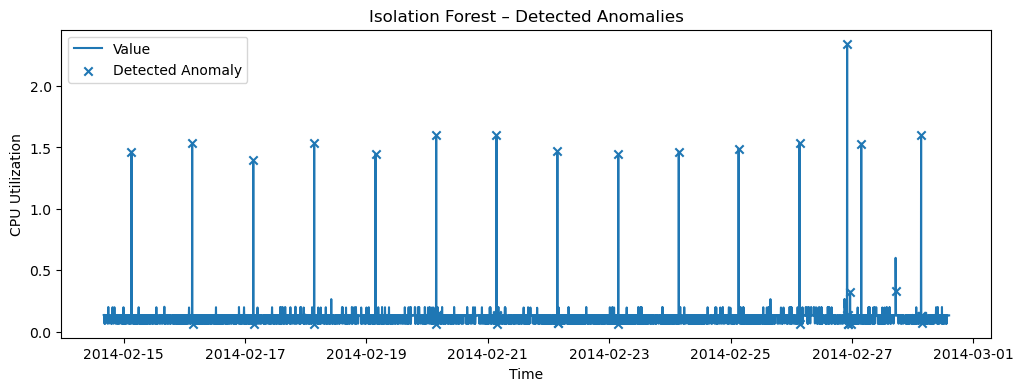

In [49]:
anomalies = df_feat[df_feat["anomaly"] == 1]

plt.figure(figsize=(12,4))
plt.plot(df_feat["timestamp"], df_feat["value"], label="Value")
plt.scatter(
    anomalies["timestamp"],
    anomalies["value"],
    label="Detected Anomaly",
    marker="x"
)
plt.legend()
plt.title("Isolation Forest – Detected Anomalies")
plt.xlabel("Time")
plt.ylabel("CPU Utilization")


# Save the plot
plt.savefig(PLOTS_DIR / "00_IFdA_ec2_cpu_timeseries.png", dpi=200, bbox_inches="tight")
plt.show()

### The Isolation Forest accurately flags extreme CPU utilization spikes while preserving normal baseline behavior, demonstrating effective unsupervised anomaly detection on operational time-series data.

## Save the model + feature configuration for Deployment

### Save artifacts

In [60]:
import joblib
from pathlib import Path

# folders
MODEL_DIR = Path("/Users/admin/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# save model + config needed at inference time
joblib.dump(iso_forest, MODEL_DIR / "isolation_forest.pkl")
joblib.dump(features, MODEL_DIR / "feature_list.pkl")

# save rolling window sizes, this helps the API use the same logic
config = {"win_short": 5, "win_long": 20}
joblib.dump(config, MODEL_DIR / "config.pkl")

print("Saved artifacts to:", MODEL_DIR.resolve())
print(list(MODEL_DIR.glob("*")))

Saved artifacts to: /Users/admin/models
[PosixPath('/Users/admin/models/feature_list.pkl'), PosixPath('/Users/admin/models/config.pkl'), PosixPath('/Users/admin/models/isolation_forest.pkl')]
